In [2]:
!pip install torch torchvision numpy matplotlib timm


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python -m pip install --upgrade pip


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [2]:
num_epochs = 20
learning_rate = 1e-4

In [27]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

# train_dataset = MNIST(root='./data', train=True, download=True, transform=transform)
# test_dataset = MNIST(root='./data', train=False, download=True, transform=transform)
train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# train_dataset, valid_dataset = random_split(train_dataset, lengths=[55000, 5000])
train_dataset, valid_dataset = random_split(train_dataset, lengths=[63257, 10000])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [ ]:
import matplotlib.pyplot as plt

# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming you have true labels and predicted labels stored
true_labels = []
pred_labels = []
model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split
from torchvision import datasets, transforms
import timm
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Step 0: Define Fourier Transform of an image
def fourier_transform(image):
    image = np.fft.fft2(image)
    image = np.fft.fftshift(image)
    magnitude = np.log(np.abs(image) + 1e-10)
    phase = np.angle(image)
    return magnitude, phase

# Step 1: Prepare MNIST Dataset with Fourier Transform applied
def prepare_datasets():
    # Define a custom transform to apply Fourier Transform
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the image to match ViT input dimensions
        transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
#         transforms.Lambda(lambda x: fourier_transform(x[0].numpy())),  # Apply Fourier Transform and handle channel
        transforms.Lambda(lambda x: torch.from_numpy(np.stack([x[0], x[0], x[0]], axis=0)).float()),  # Stack magnitude twice and phase to create 3 channels
    ])

    # Download and load the training data
    trainset = datasets.MNIST(root='./data/Fourier_MNIST_data/', train=True, download=True, transform=transform)
    testset = datasets.MNIST(root='./data/Fourier_MNIST_data/', train=False, download=True, transform=transform)
    
    trainset, valset = random_split(trainset, lengths=[55000, 5000])
    
    return trainset, valset, testset

In [3]:
# Step 2: Define Vision Transformer Model
class ViTForMNIST(nn.Module):
    def __init__(self, num_classes, pretrained_model_name='vit_tiny_patch16_224'):
        super().__init__()
        self.vit = timm.create_model(pretrained_model_name, pretrained=True)
        self.vit.head = nn.Linear(self.vit.head.in_features, num_classes)

    def forward(self, x):
        return self.vit(x)

In [4]:
# Step 3: Set up Training and Evaluation
def train(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    return (running_loss / len(train_loader)), (correct / total)

def evaluate(model, val_loader, device, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            running_loss += criterion(outputs,labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (running_loss/len(val_loader)),(correct / total)

In [5]:
# Step 4: Load datasets and initialize model
trainset, valset, testset = prepare_datasets()
train_loader = DataLoader(trainset, batch_size=16, shuffle=True)
val_loader = DataLoader(valset, batch_size=16, shuffle=False)

test_loader = DataLoader(testset, batch_size=16, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ViTForMNIST(num_classes=10)
model.to(device)

ViTForMNIST(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=192, out_features=576, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=192, out_features=192, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=192, out_features=768, bias=True)
          (act): GELU(approximate='none')
    

In [6]:
# Step 5: Set up optimizer and loss function
num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,num_epochs, eta_min=2e-7)

In [7]:
# Step 6: Train the model
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, scheduler, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(100. * train_accuracy)
    
    val_loss, val_accuracy = evaluate(model, val_loader, device, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(100. * val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.3f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy*100:.3f}')

Epoch 1/30, Train Loss: 0.1306, Train Accuracy: 95.945, Val Loss: 0.0677, Val Accuracy: 98.080
Epoch 4/30, Train Loss: 0.0165, Train Accuracy: 99.489, Val Loss: 0.0418, Val Accuracy: 98.780
Epoch 5/30, Train Loss: 0.0123, Train Accuracy: 99.604, Val Loss: 0.0309, Val Accuracy: 99.220
Epoch 6/30, Train Loss: 0.0098, Train Accuracy: 99.695, Val Loss: 0.0234, Val Accuracy: 99.460
Epoch 7/30, Train Loss: 0.0071, Train Accuracy: 99.775, Val Loss: 0.0375, Val Accuracy: 99.180
Epoch 8/30, Train Loss: 0.0083, Train Accuracy: 99.729, Val Loss: 0.0276, Val Accuracy: 99.420
Epoch 9/30, Train Loss: 0.0054, Train Accuracy: 99.831, Val Loss: 0.0322, Val Accuracy: 99.180
Epoch 10/30, Train Loss: 0.0063, Train Accuracy: 99.802, Val Loss: 0.0234, Val Accuracy: 99.500
Epoch 11/30, Train Loss: 0.0044, Train Accuracy: 99.855, Val Loss: 0.0287, Val Accuracy: 99.420
Epoch 12/30, Train Loss: 0.0042, Train Accuracy: 99.882, Val Loss: 0.0350, Val Accuracy: 99.160
Epoch 13/30, Train Loss: 0.0050, Train Accuracy

In [8]:
test_loss, test_accuracy = evaluate(model, test_loader, device, criterion)
print(f"Test Accuracy: {test_accuracy*100:0.3f} Test loss: {test_loss:0.3f}")

Test Accuracy: 99.480 Test loss: 0.024


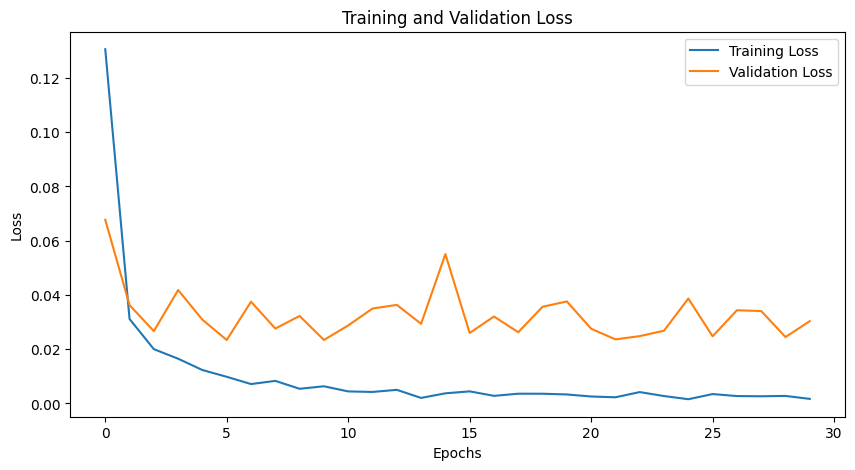

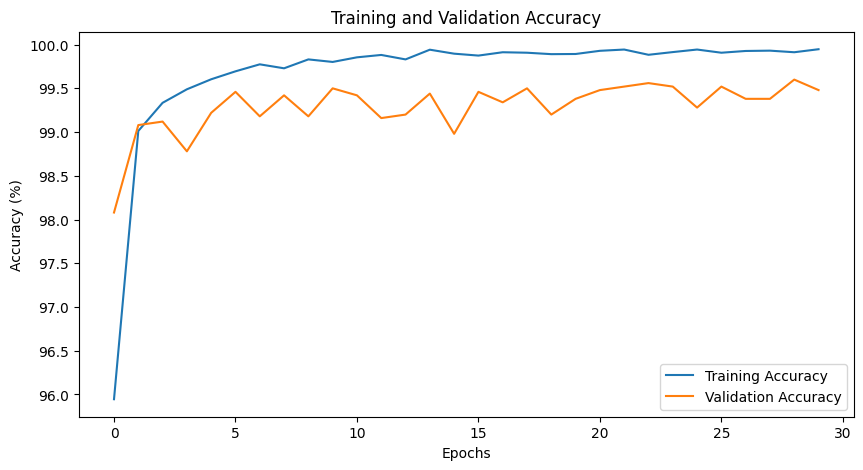

In [9]:


# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

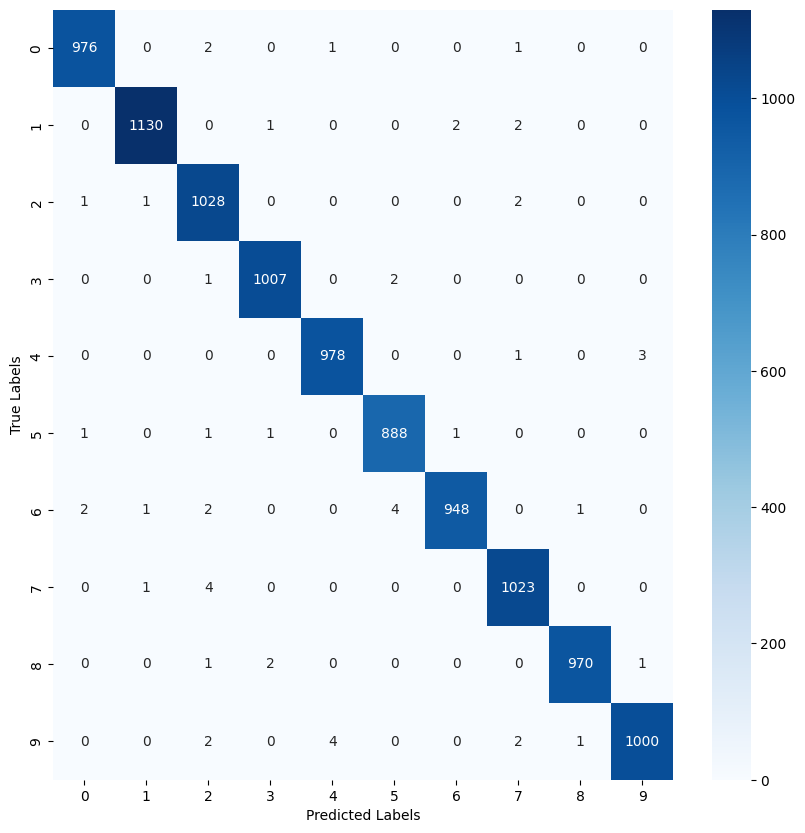

In [10]:
# Assuming you have true labels and predicted labels stored
true_labels = []
pred_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [13]:
def calculate_metrics(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = sum(confusion_matrix[:, i]) - tp
        fn = sum(confusion_matrix[i, :]) - tp

        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0

        f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

    return precision, recall, f1

In [15]:
p,r,f = calculate_metrics(cm)

In [42]:
import pandas as pd

In [17]:
df = pd.DataFrame([p,r,f],index=['Precision', 'Recall', 'F1 Score']).T
df

,Precision,Recall,F1 Score
0,0.944227,0.984694,0.964036
1,0.993772,0.984141,0.988933
2,0.949950,0.919574,0.934515
3,0.930931,0.920792,0.925834
4,0.949239,0.952138,0.950686
5,0.920617,0.936099,0.928293
6,0.973031,0.941545,0.957029
7,0.936232,0.942607,0.939409
8,0.932150,0.916838,0.924431
9,0.895594,0.926660,0.910862


In [19]:
df.mean(axis=0)

Precision    0.942574
Recall       0.942509
F1 Score     0.942403
dtype: float64

# SVHN

In [3]:
def fourier_transform_colored(image):
    # Apply FFT on each channel separately
    channels = []
    for i in range(3):  # Assuming the input image has 3 channels (RGB)
        channel = np.fft.fft2(image[i])
        channel = np.fft.fftshift(channel)
        magnitude = np.log(np.abs(channel) + 1e-10)
#         phase = np.angle(channel)
        channels.append(magnitude)
#         channels.append(phase)
    return np.stack(channels, axis=0)  # Stack magnitude and phase for each channel


In [4]:
def prepare_datasets():
    # Data augmentation and preprocessing
    transform_train = transforms.Compose([
#         transforms.RandomCrop(32, padding=4),
        transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        transforms.Resize((224, 224)),# Random cropping with padding
        transforms.ToTensor(),
        transforms.Lambda(lambda x: fourier_transform_colored(x.numpy())),
        transforms.Lambda(lambda x: torch.from_numpy(x).float())
          # Add dropout
    ])

    transform_test = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: fourier_transform_colored(x.numpy())),
        transforms.Lambda(lambda x: torch.from_numpy(x).float())
    ])
    # Download and load the training data
    trainset = datasets.SVHN(root='./data/Fourier_SVHN_data/', split='extra', download=True, transform=transform_train)
    testset = datasets.SVHN(root='./data/Fourier_SVHN_data/', split='test', download=True, transform=transform_test)
    
    trainset, valset = random_split(trainset, lengths=[511131, 20000])
    
    return trainset, valset, testset

In [5]:
# Step 2: Define Vision Transformer Model
class ViTForSVHN(nn.Module):
    def __init__(self, num_classes, pretrained_model_name='vit_small_patch16_224'):
        super().__init__()
        self.vit = timm.create_model(pretrained_model_name, pretrained=True)
        self.dropout = nn.Dropout(0.1)
        self.vit.head = nn.Sequential(
            self.dropout,
            nn.Linear(self.vit.head.in_features, num_classes)
        )
        

    def forward(self, x):
        return self.vit(x)

In [6]:
# Step 3: Set up Training and Evaluation
def train(model, train_loader, optimizer, scheduler, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        running_loss += loss.item()
    return (running_loss / len(train_loader)), (correct / total)

def evaluate(model, val_loader, device, criterion):
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            running_loss += criterion(outputs,labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return (running_loss/len(val_loader)),(correct / total)

In [10]:
# Step 4: Load datasets and initialize model
trainset, valset, testset = prepare_datasets()
train_loader = DataLoader(trainset, batch_size=512, shuffle=True)
val_loader = DataLoader(valset, batch_size=512, shuffle=False)

test_loader = DataLoader(testset, batch_size=1024, shuffle=False)

device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
model = ViTForSVHN(num_classes=10)
model.to(device)

Using downloaded and verified file: ./data/Fourier_SVHN_data/extra_32x32.mat
Using downloaded and verified file: ./data/Fourier_SVHN_data/test_32x32.mat


ViTForSVHN(
  (vit): VisionTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      (norm): Identity()
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (patch_drop): Identity()
    (norm_pre): Identity()
    (blocks): Sequential(
      (0): Block(
        (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=384, out_features=1152, bias=True)
          (q_norm): Identity()
          (k_norm): Identity()
          (attn_drop): Dropout(p=0.0, inplace=False)
          (proj): Linear(in_features=384, out_features=384, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
        )
        (ls1): Identity()
        (drop_path1): Identity()
        (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
        (mlp): Mlp(
          (fc1): Linear(in_features=384, out_features=1536, bias=True)
          (act): GELU(approximate='none')
   

In [8]:
num_epochs = 30
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer,num_epochs, eta_min=2e-7)

In [9]:
# Step 6: Train the model
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_loader, optimizer, scheduler, criterion, device)
    train_losses.append(train_loss)
    train_accuracies.append(100. * train_accuracy)
    
    val_loss, val_accuracy = evaluate(model, val_loader, device, criterion)
    val_losses.append(val_loss)
    val_accuracies.append(100. * val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy*100:.3f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy*100:.3f}')

Epoch 1/30, Train Loss: 2.0747, Train Accuracy: 25.496, Val Loss: 1.8012, Val Accuracy: 36.115
Epoch 2/30, Train Loss: 1.6861, Train Accuracy: 40.805, Val Loss: 1.6003, Val Accuracy: 44.050
Epoch 3/30, Train Loss: 1.5702, Train Accuracy: 45.172, Val Loss: 1.5341, Val Accuracy: 46.310
Epoch 4/30, Train Loss: 1.5061, Train Accuracy: 47.462, Val Loss: 1.4547, Val Accuracy: 49.315
Epoch 5/30, Train Loss: 1.4566, Train Accuracy: 49.207, Val Loss: 1.4393, Val Accuracy: 50.085
Epoch 6/30, Train Loss: 1.4141, Train Accuracy: 50.669, Val Loss: 1.5311, Val Accuracy: 47.325
Epoch 7/30, Train Loss: 1.3814, Train Accuracy: 51.819, Val Loss: 1.3569, Val Accuracy: 52.490
Epoch 8/30, Train Loss: 1.3552, Train Accuracy: 52.762, Val Loss: 1.3540, Val Accuracy: 52.475
Epoch 9/30, Train Loss: 1.3276, Train Accuracy: 53.687, Val Loss: 1.3415, Val Accuracy: 52.800
Epoch 10/30, Train Loss: 1.3067, Train Accuracy: 54.401, Val Loss: 1.3058, Val Accuracy: 54.275
Epoch 11/30, Train Loss: 1.2847, Train Accuracy: 

In [11]:
test_loss, test_accuracy = evaluate(model, test_loader, device, criterion)
print(f"Test Accuracy: {test_accuracy*100:0.3f} Test loss: {test_loss:0.3f}")

Test Accuracy: 9.323 Test loss: 3.228


In [ ]:
# Plotting training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

In [ ]:
def calculate_metrics(confusion_matrix):
    num_classes = confusion_matrix.shape[0]
    precision = np.zeros(num_classes)
    recall = np.zeros(num_classes)
    f1 = np.zeros(num_classes)

    for i in range(num_classes):
        tp = confusion_matrix[i, i]
        fp = sum(confusion_matrix[:, i]) - tp
        fn = sum(confusion_matrix[i, :]) - tp

        precision[i] = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall[i] = tp / (tp + fn) if (tp + fn) > 0 else 0

        f1[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i]) if (precision[i] + recall[i]) > 0 else 0

    return precision, recall, f1

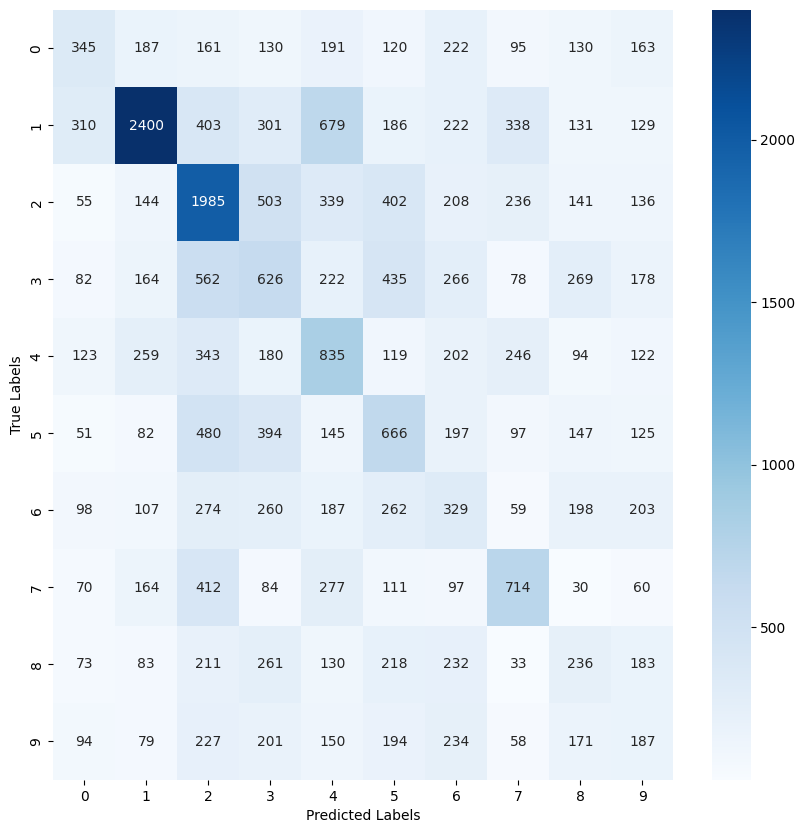

In [13]:
true_labels = []
pred_labels = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        pred_labels.extend(predicted.cpu().numpy())

cm = confusion_matrix(true_labels, pred_labels)
plt.figure(figsize=(10, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [14]:
p,r,f = calculate_metrics(cm)
df = pd.DataFrame([p,r,f],index=['Precision', 'Recall', 'F1 Score']).T
df

NameError: name 'pd' is not defined

In [67]:
def prepare_datasets_0():
    # Define a custom transform to apply Fourier Transform
    transform = transforms.Compose([
#         transforms.Resize((224, 224)),  # Resize the image to match ViT input dimensions
        transforms.ToTensor(),  # Convert PIL Image to PyTorch Tensor
#         transforms.Lambda(lambda x: fourier_transform(x[0].numpy())),  # Apply Fourier Transform and handle channel
#         transforms.Lambda(lambda x: torch.from_numpy(np.stack([x[0], x[0], x[1]], axis=0)).float()),  # Stack magnitude twice and phase to create 3 channels
    ])

    # Download and load the training data
    trainset = datasets.MNIST(root='./data/Fourier_MNIST_data/', train=True, download=True, transform=transform)
    
    
    trainset
    
    return trainset

In [100]:
trainset = prepare_datasets_0()
train_loader = DataLoader(trainset, batch_size=50000, shuffle=True)

In [101]:
visited = set()
# image_dict = {}
done = False
for images, labels in train_loader: 
    if done:
        break
    for (image, label) in zip(images, labels):
        if len(visited) == 10:
            done = True
            break
        if label not in visited:
            image_dict[label.item()] = image.numpy()
            visited.add(label.item())

In [102]:
image_dict.keys()

dict_keys([3, 4, 9, 7, 2, 0, 6, 8, 5, 1])

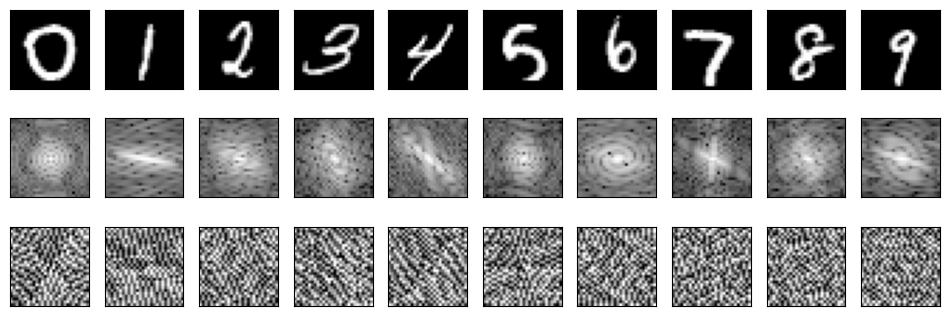

In [ ]:
fig = plt.figure(figsize=(12,4))

# plt.subplots(3,9)
for i in range(10):
    plt.subplot(3,10,i+1)
    plt.imshow(image_dict[i].transpose(1,2,0), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    fourier_image = fourier_transform(image_dict[i])
    plt.subplot(3,10,10+i+1)
    plt.imshow(fourier_image[0].transpose(1,2,0), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(3,10,20+i+1)
    plt.imshow(fourier_image[1].transpose(1,2,0), cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    

In [134]:
len(fourier_transform(image_dict[0]))

2